In [1]:
%matplotlib inline

snapshot_times = np.load('snapshot_times.npy')

In [2]:
%load_ext Cython

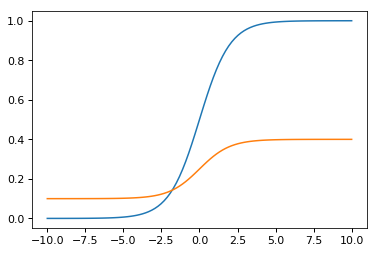

In [3]:
def logistic(x, midpoint=0, k=1, maxval=1, minval=0):
    dy_tot = maxval-minval
    denom = 1 + np.exp(-k*(x-midpoint))
    return minval + dy_tot/denom

fig, ax = plt.subplots(1, 1)

_x = np.linspace(-10, 10, 100)
__=ax.plot(_x, logistic(_x))
__=ax.plot(_x, logistic(_x, maxval=.4, minval=0.1))

In [4]:
%%cython 

import numpy as np 
from libc.stdlib cimport rand as c_rand
from libc.stdlib cimport RAND_MAX


cdef double c_random_uniform():
    cdef double r = c_rand()
    return r/RAND_MAX


def random_disruption_history(double[:] cosmic_age_array, double p, int num_gals):
    cdef int itime, igal
    cdef int num_time_steps = len(cosmic_age_array)
    cdef double uran
    cdef double t1 = cosmic_age_array[0]
    cdef double t2, dt
    cdef double[:, :] result = np.zeros((num_gals, num_time_steps), dtype='f8')
    
    for igal in range(num_gals):
        
        t1 = cosmic_age_array[0]
        for itime in range(num_time_steps):
            t2 = cosmic_age_array[itime]
            dt = t2 - t1
            if c_random_uniform() < p*dt:
                result[igal, itime] = 1.
            t1 = t2
                
    return result

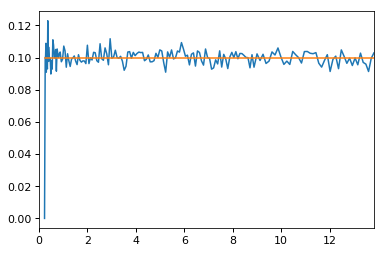

In [5]:
ngals = int(1e5)
prob_per_unit_time = 0.1

tarr = snapshot_times
dh = np.array(random_disruption_history(tarr, prob_per_unit_time, ngals))
dt = np.insert(np.diff(tarr), 0, tarr[0])

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0, tarr[-1])
__=ax.plot(tarr, np.mean(dh, axis=0)/dt)
__=ax.plot(tarr, np.zeros_like(tarr) + prob_per_unit_time)